In [1]:
# ある温度で可視光強度ごとのカーブの情報が入ったCSVデータからfitを行う
# k1k2などのfitデータのCSV、フィットした図、R2、t95、フィッティングパラメーターを保存、
# さらにこれらの情報を一つのcsvにまとめる、

In [44]:
# 1カラムのtime,absデータからnorm_time,norm_absを作成
# extracted_dataにカーブ取り出しプログラムで出力されたデータをまとめる
# vis_dataに可視光強度の積分値が入ってる

# 警告が出たらfitの初期値が合ってないので、Dを0.1倍する

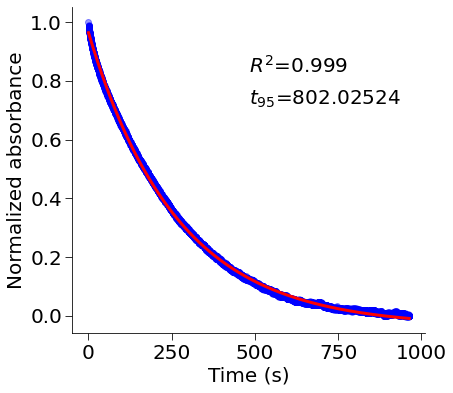

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import statistics
import numpy as np
import pandas as pd
import os
from ipywidgets import Output
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
import math
%matplotlib inline

# ハイパーパラメーター設定
# Aminで平均するプロット数: 20なら最後のデータの20個の平均をAminに用いる
plot_number = 20
# default
A = 1
B = 0
C = -1
D = -0.005

# A = 1
# B = 0
# C = -3
# D = -0.05

# 001, 010, 011, 100, 101, 110
compound = "S-C2"
temp = "-7"
light_num = "001"
# 波長があってるか注意
path = "../data/SPA_reanalyze_from_scv/" + compound + "/" + temp + "/extracted_data/510 " + light_num + ".csv"
# path = "../data/SPA_reanalyze_from_scv/" + compound + "/" + temp + "/extracted_data/" + light_num + " 490.csv"

# path = "../data/SPA_reanalyze_from_scv/S-H/0/extracted_data/490 011.csv"
temperature = int(temp)
file_name = path.split("/")[-1]
df = pd.read_csv(path)

result_dir = path.split(file_name)[0].replace("data", "result")

# naを削除してデータ数を揃える
df.dropna(inplace=True)

df = df.loc[:, (df.columns!="norm_time") & (df.columns!="norm_abs") & (df.columns!="fit_curve")]
col_list = list(df.columns)
data_num = int(len(col_list) / 2)

# データが2カラム以上のとき
if data_num != 1:
    df_output = pd.DataFrame()
#     カラム名のrename
    for i, col_name in enumerate(col_list):

        if "time" in col_name:
            df = df.rename(
                columns={col_name: "time_" + str(i//2)}
            )

        if "abs" in col_name:
            df = df.rename(
                columns={col_name: "abs_" + str((i-1)//2)}
            )

    for i in range(data_num):
        df_time = df["time_" + str(i)]
        df_abs = df["abs_" + str(i)]
        df_tail = df_abs.tail(plot_number)
        df_abs_min = statistics.mean(df_tail)
        x = df_time - df_time[0]
        y = (df_abs - df_abs_min) / (max(df_abs) - df_abs_min)
        df_time_and_abs = pd.DataFrame({"time" : x, "abs" : y})
        df_output = pd.concat([df_output, df_time_and_abs], axis=0)
    
    df = df_output
    x = df["time"]
    y = df["abs"]
    
if data_num == 1:
    df_tail = df['abs'].tail(plot_number)
    df_abs_min = statistics.mean(df_tail)

    # normalized_time
    x = df['time'] - df['time'][0]
    # normalized_abs
    y = (df['abs'] - df_abs_min) / (max(df['abs']) - df_abs_min)


# フィッティング関数
def kinetic_model_f1(x, B, C, D):
    return A*(1-((1-np.exp(D*x))/(1-C*np.exp(D*x)))) + B

    """
    最後のプロットからn個を平均した値をAminとする。
    """



data_kinetic_model_f1 = np.array([x, y])

# パラメーターの初期値 B,C,D
param_init = {
        "data_kinetic_model_f1":[B, C, D]
        }
# グラフ描画用のサンプルデータ
sample_x = np.array(x)


def fit(func, x, param_init):
    """
    func:データxに近似したい任意の関数
    x:データ
    param_init:パラメータの初期値
    popｔ:最適化されたパラメータ
    pocv:パラメータの共分散
    """
    X = x[0]
    Y = x[1]
    popt,pocv=curve_fit(func, X, Y, p0=param_init)
    perr = np.sqrt(np.diag(pocv)) #対角成分が各パラメータの標準誤差に相当
    y=func(sample_x, *popt)
    return y, popt, perr


fit_result = fit(kinetic_model_f1, data_kinetic_model_f1, param_init["data_kinetic_model_f1"])
# R2の計算
residuals =  y - fit_result[0]
rss = np.sum(residuals**2)#residual sum of squares = rss
tss = np.sum((y-np.mean(y))**2)#total sum of squares = tss
r_squared = 1 - (rss / tss)

# t_95 from k1,k2   
opt_B = fit_result[1][0]
opt_C = fit_result[1][1]
opt_D = fit_result[1][2]

k_1 = -opt_D
k_2 = -(opt_C * opt_D)/(1 - opt_C)
t_95 = (-1/k_1)*(math.log((k_1 + k_2)/(20*k_1+k_2)))



plt.rcParams["font.family"] = "sans-serif" # 使用するフォント
plt.rcParams["font.size"] = 20
# x軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
# y軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 7
# x軸副目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4

plt.rcParams["legend.frameon"] = False # 凡例を囲うかどうか、Trueで囲う、Falseで囲わない

fig, ax = plt.subplots(1, 1, figsize=(7, 6))



# x軸ラベルの下に空間を生成
# ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')
# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized absorbance')
ax.annotate("$R^2$="+str(np.round(r_squared,5)), xy=(0.5, 0.8), xycoords='axes fraction')
ax.annotate("$t_{95}$="+str(np.round(t_95,5)), xy=(0.5, 0.7), xycoords='axes fraction')
fig.subplots_adjust(left=0.2)

ax.scatter(data_kinetic_model_f1[0], data_kinetic_model_f1[1], color="blue", alpha=0.4)

fitted_arr = np.array([sample_x, fit_result[0]])
fitted_df = pd.DataFrame({"time":fitted_arr[0], "abs":fitted_arr[1]})
fitted_df.sort_values("time", inplace=True)
ax.plot(fitted_df["time"], fitted_df["abs"], color="red", lw='3')


# 元データ、ノーマライズ後、フィットカーブも追加してcsvへ保存
df['norm_time'] = x
df['norm_abs'] = y
df['fit_curve'] = fit_result[0]
# df_resultの保存
os.makedirs(result_dir, exist_ok=True)
df.to_csv(result_dir + file_name, index=False)

# フィットデータの保存
opt_B = fit_result[1][0]
opt_C = fit_result[1][1]
opt_D = fit_result[1][2]

k_1 = -opt_D
k_2 = -(opt_C * opt_D)/(1 - opt_C)

column_name = file_name.split(".csv")[0]

opt_columns = ["opt_B", "opt_C", "opt_D", "k_1", "k_2", "t95"]
opt_params = np.array([opt_B, opt_C, opt_D, k_1, k_2, t_95])

df_opt_params = pd.DataFrame(opt_params, index=opt_columns, columns=[column_name])

fit_result_dir = result_dir + "fit_result/"
os.makedirs(fit_result_dir, exist_ok=True)
df_opt_params.to_csv(fit_result_dir + file_name, index=True)
fig_result_dir = result_dir + "fig_result/"
os.makedirs(fig_result_dir, exist_ok=True)
fig.savefig(fig_result_dir + column_name + ".png", bbox_inches='tight', pad_inches=0)

# 全ての可視光強度でのフィッティングが終わったら：ファイルの結合 (解析したそれぞれの可視光強度下での結果を一つのcsvにまとめる)、fit_resultフォルダに保存されたcsvファイルが結合、保存される

In [294]:
import glob
import codecs

df_opt_params_all = pd.DataFrame()
data_dir = fit_result_dir + "*.csv"
# 手動
# data_dir = ""
paths = [p for p in glob.glob(data_dir)]

for path in paths:
    with codecs.open(path, "r", "UTF-8", "ignore") as file:
        df = pd.read_csv(file)
        df = df.rename(
            columns={df.columns[0]: "params"}
        )
        df = df.set_index("params")
        df_opt_params_all = pd.concat([df_opt_params_all, df], axis=1)

# dfの転置、sortで番号順に並び替え

df_opt_params_all_T = df_opt_params_all.T

sorted_list = []
sorted_dict = {}
dict_origin = {}
order_i_list = []
idx_df_opt_params_all_T = df_opt_params_all_T.index
for (i, c) in enumerate(idx_df_opt_params_all_T):
    dict_origin.update({"order_" + str(i): i, "value_" + str(i): c})

for l in idx_df_opt_params_all_T:
    sorted_list.append(int(l.replace(" ", "")))

sorted_list = sorted(sorted_list)
    
for (i, c) in enumerate(sorted_list):
    sorted_dict.update({"order_" + str(i): i, "value_" + str(i): c})
    order_i_list.append(i)


sorted_order_i_list = []
for i in order_i_list:
#     print(sorted_dict["order_" + str(i)])
#     print(sorted_dict["value_" + str(i)])
    for j in order_i_list:
        if int(dict_origin["value_" + str(i)].replace(" ", "")) == sorted_dict["value_" + str(j)]:
            sorted_order_i_list.append(j)

df_opt_params_all_T["sorted_order"] = sorted_order_i_list
df_opt_params_all_T = df_opt_params_all_T.sort_values("sorted_order")


# 保存
os.makedirs(fit_result_dir + "concat", exist_ok=True)
df_opt_params_all_T.to_csv(fit_result_dir + "concat/result_df.csv", index=True)

# vis_data_dir部分は温度ごとに編集

In [295]:
# concat/のデータを用いてkp1, kp2, kt1, kt2を算出する
vis_data_dir = (result_dir.split("extracted_result")[0] + "vis_data/SPA re-analyze_S-B2_-7_vis.csv").replace("result/", "data/")
vis_data_df = pd.read_csv(vis_data_dir)
# result_dir = data_dir.split("*.csv")[0].replace("data", "result")

fit_data_dir = result_dir + "fit_result/concat/result_df.csv"
fit_data_df = pd.read_csv(fit_data_dir)

fit_data_vis_df = pd.concat([fit_data_df, vis_data_df["light intensity"]], axis=1)

[0.00075268 0.00162566 0.00332651 0.00057917]


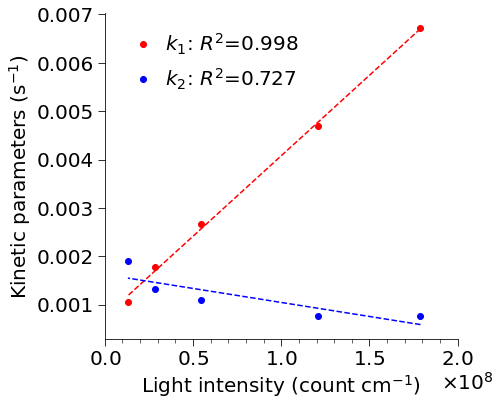

In [296]:
x_min = 0
x_max = 17.5
# X軸によってどちらかに設定
# x_ticks = [0, 5*(10**7), 10*(10**7), 15*(10**7)]
x_ticks = [0, 5*(10**7), 10*(10**7), 15*(10**7), 20*(10**7)]

# ラベルに10^7を表示するのでx軸を10^7で割る
x = fit_data_vis_df["light intensity"]
y_1 = fit_data_vis_df["k_1"]
y_2 = fit_data_vis_df["k_2"]

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 20

#軸主目盛り線の長さ
plt.rcParams["xtick.major.size"] = 7
plt.rcParams["ytick.major.size"] = 7
#x軸補助目盛り線の長さ
plt.rcParams["xtick.minor.size"] = 4
# plt.rcParams['figure.subplot.bottom'] = 0.15
# plt.rcParams['figure.subplot.left'] = 0.2
plt.rcParams["legend.frameon"] = False

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.set_xlabel('Light intensity (count $\mathrm{cm^{-1}}$)')
# ax.set_xlabel('Light intensity ($10^{7}$ count $\mathrm{cm^{-1}}$)')
ax.set_ylabel('Kinetic parameters ($\mathrm{s^{-1}}$)')

# 軸の最大値、最小値、表示メモリ設定
ax.set_xlim(x_min, x_max)
ax.set_xticks(x_ticks)

# x軸ラベルの下に空間を生成
# ax.get_xaxis().set_tick_params(pad=8)

# 目盛りを外に出す
ax.tick_params(direction='out')

# 1.0間隔で補助メモリ
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10000000))

# ×10表記
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.get_xaxis().get_offset_text().set_position((1.1,0))

# 枠線の消去
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.2)
# ax.plot(x, y_1, "o", color="red", lw='1')
# # ax.annotate("$k_1$", xy=(0.6, 0.8), xycoords='axes fraction')
# ax.plot(x, y_2, "o", color="blue", lw='1', label="")
# # ax.annotate("$k_2$", xy=(0.6, 0.7), xycoords='axes fraction')

# x: 可視光強度

def func(x, a, b):
    f = a*x + b
    return f

def func_kp1(light_intensity, slop, intercept):
    k1 = slop*light_intensity + intercept
    kt1 = intercept
    kp1 = k1 - kt1
    return kp1

def func_kp2(light_intensity, slop, intercept):
    k2 = slop*light_intensity + intercept
    kt2 = intercept
    kp2 = -k2 + kt2
    return kp2

# k1のフィット 
# popt_1[0],popt[1]に傾き(slop)、切片(kt1)
popt_1, pcov_1 = curve_fit(func,x,y_1)

residuals_1 =  y_1 - func(x, popt_1[0],popt_1[1])
rss_1 = np.sum(residuals_1**2)#residual sum of squares = rss
tss_1 = np.sum((y_1-np.mean(y_1))**2)#total sum of squares = tss
r_squared_1 = 1 - (rss_1 / tss_1)

# kt1, kp1の算出　光強度10^8のとき
k_t1 = popt_1[1]
k_p1 = func_kp1(10**8, popt_1[0],popt_1[1])

# k2のフィット
popt_2, pcov_2 = curve_fit(func,x,y_2)

residuals_2 =  y_2 - func(x, popt_2[0],popt_2[1])
rss_2 = np.sum(residuals_2**2)#residual sum of squares = rss
tss_2 = np.sum((y_2-np.mean(y_2))**2)#total sum of squares = tss
r_squared_2 = 1 - (rss_2 / tss_2)

ax.plot(x, y_1, "o", color="red", lw='1', label="$k_1$: $R^2$="+str(np.round(r_squared_1,3)))
ax.plot(x,func(x, popt_1[0],popt_1[1]),'--', color="red")
ax.plot(x, y_2, "o", color="blue", lw='1', label="$k_2$: $R^2$="+str(np.round(r_squared_2,3)))
ax.plot(x,func(x, popt_2[0],popt_2[1]),'--', color="blue")

# kt2, kp2の算出　光強度10^8のとき
k_t2 = popt_2[1]
k_p2 = func_kp2(10**8, popt_2[0], popt_2[1])

# 凡例表示
ax.legend(handletextpad=0.1)

# fig.subplots_adjust(left=0.4)

parameters_list = np.array([k_t1, k_t2, k_p1, k_p2])
print(parameters_list)

# 横軸のスケールと凡例の位置okなら画像を保存

In [297]:
# kp1, kp2, kt1, kt2を保存
df_parameters = pd.DataFrame(parameters_list.reshape(1,-1), index=[temperature], columns=["k_t1", "k_t2", "k_p1", "k_p2"])
df_parameters_dir = result_dir.split('vis')[0] + 'kinetic_parameters/'
os.makedirs(df_parameters_dir, exist_ok=True)
df_parameters.to_csv(df_parameters_dir + str(temperature) + "_parameters.csv", index=True)
fig.savefig(df_parameters_dir + str(temperature) + "_parameters.png", bbox_inches='tight', pad_inches=0)

print(parameters_list) #kt1,kt2,kp1,kp2

[0.00075268 0.00162566 0.00332651 0.00057917]


# 温度データの統合：concat_parameter_dfで処理する